In [6]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

d:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)

# Selecionar os índices com base nos critérios fornecidos
ecg_normal_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 13] == True) ]
ecg_ST_linhas = dados.index[((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == True) & (dados.iloc[:, 9] == False)  ]

ecg_ST_id = dados.iloc[ecg_ST_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()



ecg_ST = ecg_ST_id[:500]
ecg_normal = ecg_normal_id[:10000]

ids_ecgs= ecg_ST + ecg_normal

ids_ecgs_treino = ecg_normal_id[10001:11001] + ecg_ST_id[501:551]

In [8]:
#X
def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings
        
# Caminho para o arquivo HDF5
path_to_file = '../Database/filtered_exams.hdf5'  # Substitua pelo caminho real do arquivo

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    tracings = get_ecg_data(path_to_file, exam_id)
    aa = np.array(tracings.T)
    all_tracings.append(aa)

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])



In [9]:
#X_TREINO

exam_ids_to_cluster_treino = ids_ecgs_treino  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster_treino:
    tracings = get_ecg_data(path_to_file, exam_id)
    aa = np.array(tracings.T)
    all_tracings.append(aa)

# X será um array com um único array dentro, contendo todos os números do tracings.T
X_TREINO = np.array(all_tracings)
 
# Usando squeeze
X_TREINO = np.squeeze(X_TREINO[:, 1, :])

In [10]:
#CARREGAR MODELO

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

# Define the encoder
def encoder_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=40, kernel_size=16, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=40, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    encoded = Conv1D(filters=1, kernel_size=16, strides=1, padding='same')(x)

    return Model(inputs, encoded, name="encoder")

# Define the decoder
def decoder_model(encoded_shape):
    inputs = Input(shape=encoded_shape)
    x = Conv1DTranspose(filters=40, kernel_size=16, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=40, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    decoded = Conv1DTranspose(filters=1, kernel_size=16, strides=2, padding='same')(x)

    return Model(inputs, decoded, name="decoder")

# Define the full autoencoder
def autoencoder_model(input_shape):
    encoder = encoder_model(input_shape)
    decoder = decoder_model(encoder.output_shape[1:])
    
    inputs = Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    
    autoencoder = Model(inputs, decoded, name="autoencoder")
    
    return autoencoder




Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 69s 201ms/step - loss: 0.0661 - val_loss: 0.0228
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 197ms/step - loss: 0.0219 - val_loss: 0.0216
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 53s 202ms/step - loss: 0.0212 - val_loss: 0.0208
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 198ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - loss: 0.0171 - val_loss: 0.0186
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - loss: 0.0125 - val_loss: 0.0156
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 54s 207ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 12/50
263/263

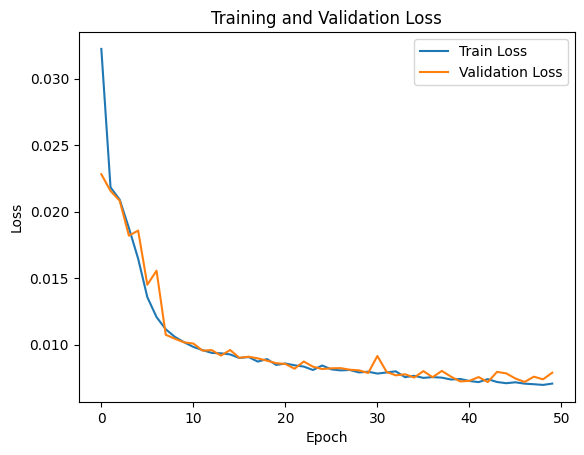

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


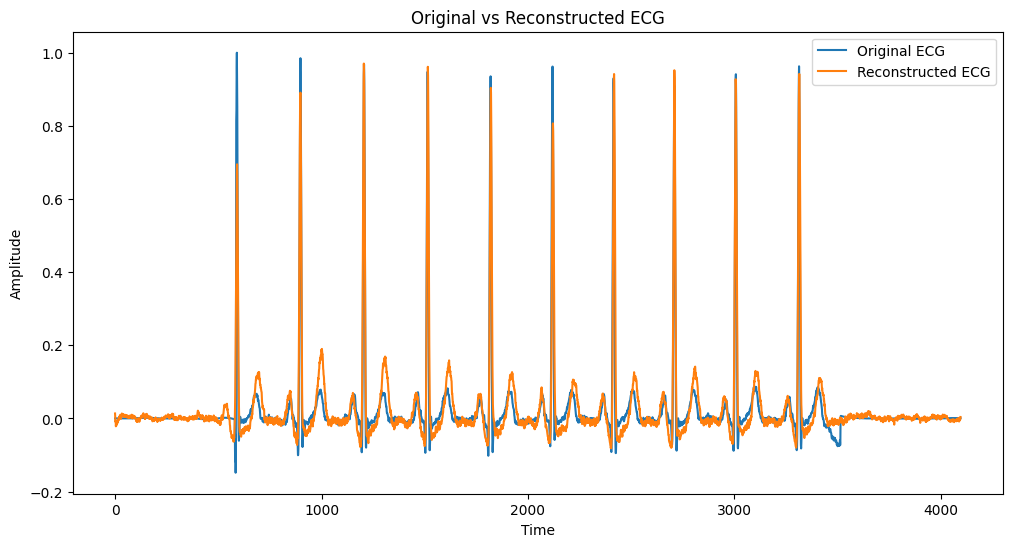

In [11]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Definir o autoencoder
autoencoder = autoencoder_model((4096, 1))
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# Plotar a perda de treino e validação
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()

# Salvar o modelo treinado no formato Keras
autoencoder.save('autoencoder_model_16.keras')

# Salvar o modelo treinado
autoencoder.save('autoencoder_model_16.h5')


In [12]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

# Carregar o modelo autoencoder
autoencoder = tf.keras.models.load_model('modelos/autoencoder_model.keras')

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

d:\python\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
(10500, 128, 1)
(10500, 128)


In [10]:
#DIMINUIR DIMENSAO DE X_TREINO PELO AUTOENCODER(128)


# Carregar o modelo autoencoder
autoencoder = tf.keras.models.load_model('modelos/autoencoder_model.keras')

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X_TREINO já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X_TREINO = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X_TREINO = X_TREINO / np.max(np.abs(X_TREINO), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X_TREINO = X_TREINO.reshape((X_TREINO.shape[0], X_TREINO.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X_TREINO
X_encoded = encoder.predict(X_TREINO)

# X_encoded agora contém os vetores de 128 números para cada entrada em X_TREINO


# Remover a última dimensão para obter um vetor 2D
X_TREINO_encoded_2d = np.squeeze(X_encoded)



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [11]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

In [12]:
#DIMINUIR DIMENSAO DE X_TREINO PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_TREINO_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=16, random_state=42)
X_TREINO_reduced = umap_reducer.fit_transform(X_normalized)

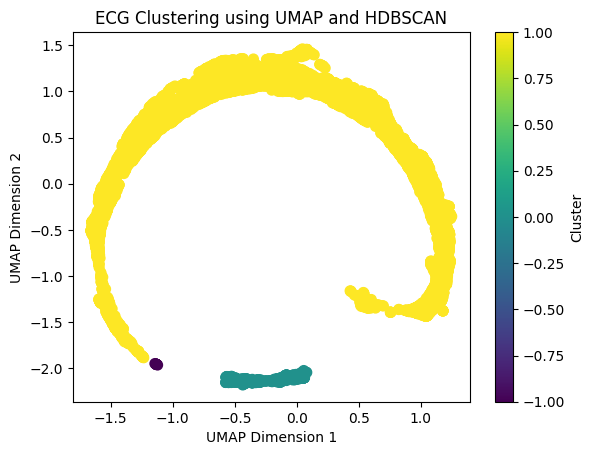

Silhouette Score: 0.29022347927093506
   cluster  1dAVb  RBBB  LBBB  SB   ST  AF  normal_ecg
0       -1      0     0     0   0    0   0          10
1        0      0     0     0   0  362   0          47
2        1      0     0     0   0  138   0        9943


In [13]:
#CLUSTERIZACAO HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=300, min_samples=5)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')


# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

In [1]:
#TENTAR PREVER O TREINO NOS CLUSTERS
# Normalizar os dados
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)
new_data_scaled = scaler.transform(X_TREINO_reduced)

# Treinar o modelo HDBSCAN com prediction_data=True
dbscan = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=5, prediction_data=True)
labels = dbscan.fit_predict(X_reduced_scaled)

# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster')
plt.show()

# Calcular Silhouette Score
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Para predizer novos dados
new_data = new_data_scaled # Certifique-se de que seus novos dados estão normalizados corretamente

# Usar approximate_predict para prever os rótulos dos novos dados
try:
    new_labels, new_probabilities = hdbscan.approximate_predict(dbscan, new_data)
except AttributeError as e:
    print("Erro na previsão: ", e)
    new_labels = np.array([])

# Configurar para mostrar todos os elementos no print
np.set_printoptions(threshold=np.inf)

print("New labels:", new_labels)
print("New probabilities:", new_probabilities)


KeyboardInterrupt

